In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

Custom function also referenced in TempComparisons.ipynb to clean data

In [2]:
def cleaning_data(df):
    #df=df.reset_index()
    #casting date field to datetime format to utilise .dt.month attribute
    df['dt'] = pd.to_datetime(df['dt'])
    #creating a dictionary of the fields with null values
    dictionary = (df.isna().any()==True).to_dict()
    
    #iterating through the dictionary to find where True
    for col,val in dictionary.items():
        if val == True:                  
            #creating a dataframe of the null values
            null_df = df[df.isna()[col]==True]

            for i in null_df.index:
                month = df.loc[i,'dt'].to_pydatetime().month
                mean = df[df["dt"].dt.month == month].dropna()[col].mean()
                df.at[i,col]=mean

Loadoing in the Temperatures by country dataset

In [3]:
dataset2 = pd.read_csv('GlobalLandTemperaturesByCountry.csv',index_col=['dt'])
dataFrame2 =pd.DataFrame(dataset2)
dataFrame2=dataFrame2.reset_index()

For this piece of analysis I want to see if the rising temperatures are having an impact on the sea ice extent. For this I will use the dataset provided by the National Snow and Ice Data Center (https://nsidc.org/data/modis/data_summaries#sea-ice). This website contains excel spreadsheets with sea ice extent (km^2). In the below code block, ive done a webscrap to their API to check out what files they have available.

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import requests
from bs4 import BeautifulSoup
url = 'https://masie_web.apps.nsidc.org/pub//DATASETS/NOAA/G02135/seaice_analysis/'
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)


for file in soup.find_all('a'):
    print(file.get('href'))



?C=N;O=D
?C=M;O=A
?C=S;O=A
?C=D;O=A
/pub/DATASETS/NOAA/G02135/
Arctic_region_mask_Meier_AnnGlaciol2007.msk
Arctic_region_mask_Meier_AnnGlaciol2007.txt
N_Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx
N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx
S_Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx
S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx
Sea_Ice_Index_Daily_Extent_G02135_v3.0.xlsx
Sea_Ice_Index_Min_Max_Rankings_G02135_v3.0.xlsx
Sea_Ice_Index_Monthly_Data_by_Year_G02135_v3.0.xlsx
Sea_Ice_Index_Monthly_Data_with_Statistics_G02135_v3.0.xlsx
Sea_Ice_Index_Rates_of_Change_G02135_v3.0.xlsx


The dataset I am interested in is N_Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx. For this analysis, i am going to look at the temperature changes in Greenland and compare it against the sea ice extent in the Bafflin Sea (Sea between Greenland and Northern Canada.

In [6]:
#using pandas read_excel function to load in the dataset
url = 'https://masie_web.apps.nsidc.org/pub//DATASETS/NOAA/G02135/seaice_analysis/N_Sea_Ice_Index_Regional_Daily_Data_G02135_v3.0.xlsx'
file = pd.read_excel(url,sheet_name=None)
#xls = pd.ExcelFile(file)

In [7]:
file2 = pd.read_excel(url,sheet_name=1)
dataframeSI = pd.DataFrame(file2)
dataframeSI.head()

,month,day,1978,1979,1980,1981,1982,1983,1984,1985,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,January,1,NaN,903186.035,1013769.883,1033270.716,1023094.590,1347723.970,1309901.559,1341199.586,...,970785.241,836904.594,1042165.178,919851.203,1107737.558,1043957.619,852411.168,919098.691,789284.700,796302.334
1,NaN,2,NaN,928997.908,999873.492,1050801.408,1021066.245,1372848.377,1350548.340,1360997.397,...,988757.101,846580.138,1045929.234,952044.039,1118000.089,1041095.765,872204.561,946538.006,795458.613,812570.445
2,NaN,3,NaN,947432.787,1000897.098,1041880.956,1013746.335,1417371.453,1372754.604,1376789.972,...,999673.091,853340.629,1044428.577,984973.384,1126274.372,1039445.720,891754.362,968084.226,800215.171,829618.156
3,NaN,4,NaN,974928.335,997687.620,1037514.096,1030366.773,1460409.917,1392297.001,1398633.692,...,1006333.892,863309.928,1047832.206,1008812.804,1131821.502,1040792.446,912064.230,993647.766,800092.268,845673.961
4,NaN,5,NaN,1005270.542,1015031.822,1018820.331,1040308.602,1491475.904,1431611.850,1421457.076,...,1010444.124,877502.215,1047953.087,1031026.911,1137901.759,1055976.206,926768.633,1012670.518,806016.937,859641.485


In [8]:
#selecting the sheet that relates to the Bafflin Sea
file2 = pd.read_excel(url,sheet_name=1)
dataframeSI = pd.DataFrame(file2)

#I need to forward fill the month column to do the nature of the excel spreadsheet
dataframeSI['month']=dataframeSI['month'].fillna(method='ffill')

#mapping the month names to months as digits
look_up = {'January':'01', 'February':'02', 'March':'03', 'April':'04', 'May':'05',
           'June':'06','July':'07', 'August':'08', 'September':'09', 'October':'10',
           'November':'11', 'December':'12'}

#using lambda to update the month column using the above dictionary
dataframeSI['month'] = dataframeSI['month'].apply(lambda x: look_up[x])

As you can see from the above dataframe the years are columns but for my analysis i want the years to be rows and to concatenate the month,day and year columns to create a "date" column. This is what the below piece of code aims to do:

In [9]:
col_list = dataframeSI.keys()[2:]
i = 0
for col in col_list:
    df = dataframeSI[['month','day',col]]
    df = df.rename(columns = {col:"Extent"})
    df['Year'] = str(col)
    if i==0:
        df_corrected = df
    else:
        df_corrected= pd.concat([df_corrected,df],ignore_index=True,sort=True)
    i+=1
  

In [10]:
df_corrected=df_corrected.dropna()
df_corrected['Date']=pd.to_datetime(df_corrected[['Year', 'month', 'day']])

In [11]:
#Thats much better!
df_corrected.head()

,Extent,Year,day,month,Date
301,521862.289,1978,28,10,1978-10-28
302,521862.289,1978,29,10,1978-10-29
303,531533.703,1978,30,10,1978-10-30
304,539494.751,1978,31,10,1978-10-31
305,549767.557,1978,1,11,1978-11-01


In [12]:
#Selecting out the greenland data
greenLandTemp = dataFrame2[dataFrame2['Country']=='Greenland']
cleaning_data(greenLandTemp)
greenLandTemp=greenLandTemp.set_index('dt')


#since the sea ice data only ranges between 1979-2013, i am only interested in this data for greenland
greenLandTemp=greenLandTemp['1979-01-01':'2013-09-01']
greenLandTemp=greenLandTemp.reset_index()

This custom function allows me to input any particular month of the year and compare the average temperatures and sea ice extent for greenland using a scatter plot

In [13]:
def plot_Temp_Data(month):
    
    #selecting from sea ice dataset for inputed month
    monthly_data = df_corrected[df_corrected['Date'].dt.month == month]
    
    #getting the mean for that month for each year
    monthly_mean = monthly_data.groupby('Year',as_index=False)['Extent'].agg('mean')
    #merging to get the date for each average extent
    monthly_mean = monthly_mean.merge(monthly_data[monthly_data['day']==1][['Year','Date']],
                                      how='right',left_on='Year',right_on='Year')
    
    #plotting the data
    fig,ax = plt.subplots(figsize=(12,8))
    monthly_mean = monthly_mean.set_index('Date')['1979-07-01':'2013-07-01'].reset_index()
    x_data_mean = monthly_mean['Date']
    y_data_mean = monthly_mean['Extent']
    
    ax.plot(x_data_mean,y_data_mean,color='r',marker='v',linestyle='-')
    
    #plotting the average temp for greenland
    monthly_Temp = greenLandTemp[greenLandTemp['dt'].dt.month == month]
    y_temp = monthly_Temp['AverageTemperature']
    x_temp = monthly_Temp['dt']
           
    ax2 = ax.twinx()
    ax2.plot(x_temp,y_temp,color='g',marker='o',linestyle='--')
    ax2.set_ylabel('Average Temperature (Celcius)',color='g')
    
    #using the below dictionary to map the inputed month digit to the month as a string
    month_val = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May',
               6:'June',7:'July', 8:'August', 9:'September', 10:'October',
               11:'November', 12:'December'}
    
    month= month_val.get(month)
    
    ax.set_xlabel('Date (years)')
    ax.set_ylabel('Sea Ice Extent (km^2)',color='r')
    ax.set_title('Sea Ice extent vs Temperature for %s' %month,size=20)
    ax.tick_params('y')
    ax.tick_params('x',colors='blue')
    plt.grid(True)
    plt.savefig('SeaIceTemp.png', bbox_inches='tight')
    plt.show()   

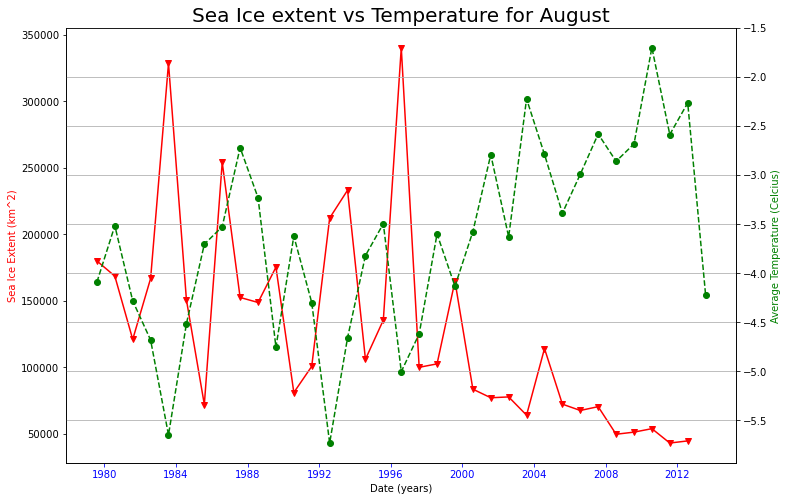

In [14]:
plot_Temp_Data(8)

# Looking closer at the Sea Ice Extent in the Bafflin Sea over time

In [15]:
import seaborn as sns

#recasting the year column to a integer
for index,rows in df_corrected.iterrows():
    df_corrected['Year'][index] = int(rows['Year'])

In [16]:
#Selecting out sea ice extent for summer months and between the years 1980-2015
df_Summer=df_corrected[(df_corrected['Year']>1980) 
                       &(df_corrected['Year']<2015)
                       & (df_corrected['month'].isin(['06','07','08']))]


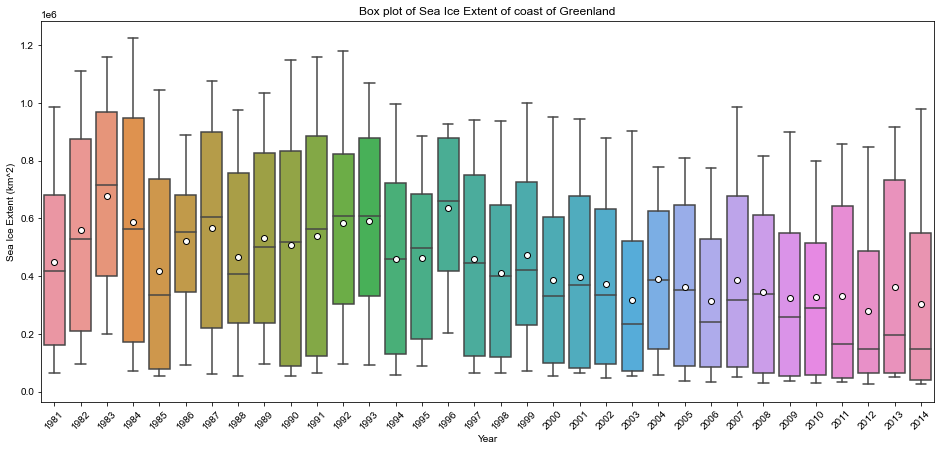

In [17]:
fig, ax = plt.subplots(figsize=(16,7))
sns.set_theme(style="whitegrid")
sns.boxplot(x="Year", y="Extent", data=df_Summer,showmeans=True, 
                     meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"6"})

plt.xticks(rotation=45);
ax.set_ylabel('Sea Ice Extent (km^2)')
ax.set_title('Box plot of Sea Ice Extent of coast of Greenland');
plt.savefig('SeaIceBoxPlot.png', bbox_inches='tight')
plt.show()
#line in the middle outlines the median
#white o marker indicates the mean value
#whiskers outline the max and min values
#box part outlines the interquartile range

# Using seaborns Regplot regression model to illustrate the mean extent change over time

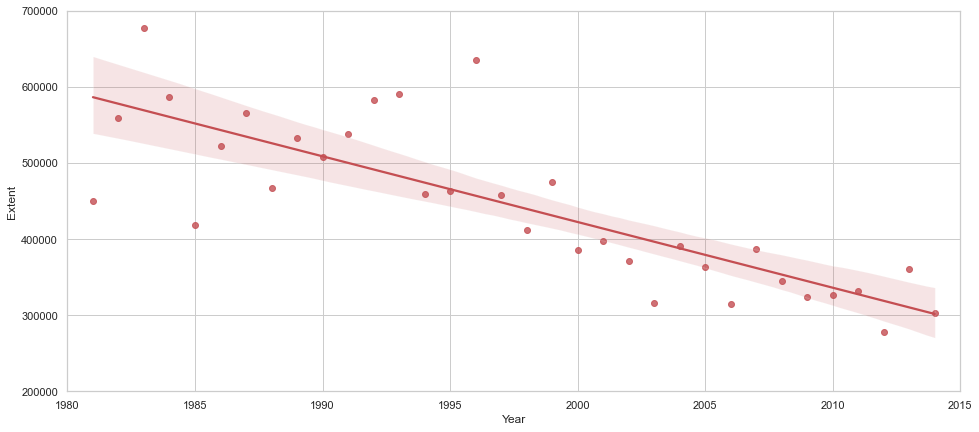

In [18]:
means=df_Summer.groupby('Year')['Extent'].mean().reset_index()
fig, ax = plt.subplots(figsize=(16,7))
sns.regplot(x=means['Year'],y=means['Extent'],data=means,color='r')
ax.set_xlim(1980,2015)
ax.set_ylim(200000,700000)
plt.savefig('SeaIceMean.png', bbox_inches='tight')